## Домашняя работа № 2

### 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

Для начала восстанавливаем историю операций по обработке датасета, выполненных на уроке

In [1]:
import pandas as pd
pd.options.display.max_columns = 30

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

#### Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\Smart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 21.5 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 50s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 26.4 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.47341427), (5, 0.117359646), (9, 0.3427769), (19, 0.047704652)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: превысить кухня компромисс шкала внуково профилактический белград
topic_1: участок теория ким студия музыка документация выставочный
topic_2: область район рейс форум москва регион городской
topic_3: nn это который год первый стать свой
topic_4: украина это россия президент газ который российский
topic_5: журнал белоруссия обращение минск мышь польша латвия
topic_6: китай остров японский турецкий япония nn место
topic_7: россия человек российский это исследование путин который
topic_8: гражданин снижение активность доклад фронт народный корпус
topic_9: лаборатория конструкция вода компьютерный австралия особенность модернизация
topic_10: это год который мочь человек свой всё
topic_11: который россия год nn это также проект
topic_12: женщина мужчина тело журнал общество офицер полиция
topic_13: авария ск треть диапазон индия негативно ухо
topic_14: мозг рак пациент фильм лечение пища подсчитать
topic_15: год млрд рост рубль компания цена уровень
topic_16: земля который погибнут

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.000000,0.876310,0.000000,0.000000,0.0,0.0,0.041980,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.073755,0.0,0.0,0.000000,0.0
1,4896,0.0,0.0,0.0,0.203867,0.000000,0.230050,0.000000,0.0,0.0,0.000000,0.0,0.544066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,4897,0.0,0.0,0.0,0.473525,0.000000,0.117339,0.000000,0.0,0.0,0.342757,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047634,0.000000,0.0,0.0,0.000000,0.0
3,4898,0.0,0.0,0.0,0.948173,0.000000,0.040974,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,4899,0.0,0.0,0.0,0.000000,0.328737,0.058782,0.256181,0.0,0.0,0.000000,0.0,0.289884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.044106,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

#### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.04276629, 0.        ,
       0.        , 0.        , 0.19117622, 0.        , 0.        ,
       0.15493156, 0.14061622, 0.        , 0.        , 0.        ,
       0.04759304, 0.31944445, 0.02730687, 0.        , 0.        ,
       0.        , 0.        , 0.06585055, 0.        , 0.        ])

In [23]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.02094685, 0.03132728, 0.20280272,
       0.        , 0.01736907, 0.08625846, 0.00651831, 0.00662908,
       0.13500985, 0.13328   , 0.01195516, 0.        , 0.00306454,
       0.05659873, 0.02419256, 0.00333038, 0.03755301, 0.02625672,
       0.01434412, 0.        , 0.00233771, 0.00966232, 0.15765756])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [25]:
#users['articles'].iloc[33]

In [26]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.057000,0.060199,0.105051,0.000000,0.000000,0.091984,0.002758,0.025408,0.104073,0.070387,0.031478,0.008983,0.000000,0.007932,0.079220,0.004551,0.002357,0.049235,0.091328,0.0,0.039209,0.104270,0.048008
1,u108690,0.0,0.0,0.028886,0.065595,0.242714,0.001863,0.002645,0.055581,0.000000,0.010811,0.156436,0.095141,0.008832,0.004319,0.006199,0.042960,0.042306,0.000000,0.030529,0.041252,0.030588,0.0,0.007445,0.004126,0.100878
2,u108339,0.0,0.0,0.054650,0.064999,0.131722,0.000000,0.021098,0.100949,0.003230,0.000000,0.085067,0.148495,0.012441,0.003642,0.004256,0.012966,0.066618,0.007956,0.048191,0.039653,0.093315,0.0,0.000000,0.004732,0.072501


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [28]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.057000,0.060199,0.105051,0.000000,0.000000,0.091984,0.002758,0.025408,0.104073,0.070387,0.031478,0.008983,0.000000,0.007932,0.079220,0.004551,0.002357,0.049235,0.091328,0.0,0.039209,0.104270,0.048008,0
1,u108690,0.0,0.0,0.028886,0.065595,0.242714,0.001863,0.002645,0.055581,0.000000,0.010811,0.156436,0.095141,0.008832,0.004319,0.006199,0.042960,0.042306,0.000000,0.030529,0.041252,0.030588,0.0,0.007445,0.004126,0.100878,1
2,u108339,0.0,0.0,0.054650,0.064999,0.131722,0.000000,0.021098,0.100949,0.003230,0.000000,0.085067,0.148495,0.012441,0.003642,0.004256,0.012966,0.066618,0.007956,0.048191,0.039653,0.093315,0.0,0.000000,0.004732,0.072501,1


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], test_size = 0.20, random_state=29)

In [32]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06397359, 0.02797805, 0.60550691, 0.01974461, 0.15146296,
       0.07642457, 0.02628966, 0.00273755, 0.40886903, 0.00770533])

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.264288, F-Score=0.648, Precision=0.642, Recall=0.655


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1331   72]
 [  69  128]]


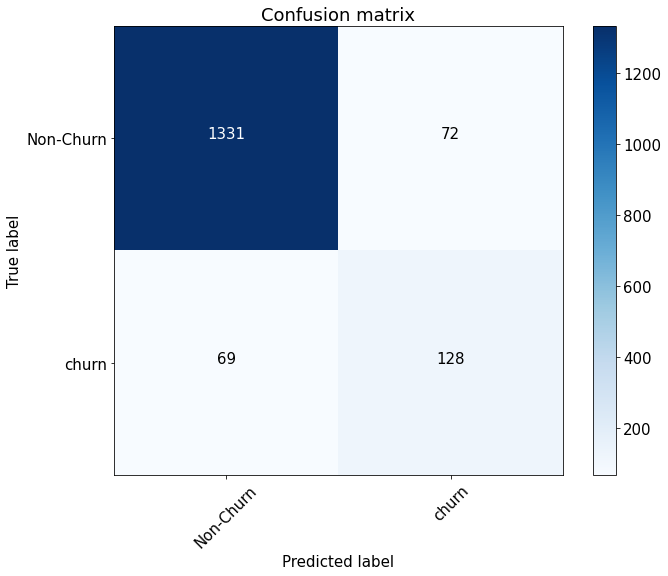

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [38]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9331779978363984

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

In [39]:
# roc_auc, precision, recall, f_score
# mean, median, max, idf_mean
score_compare = pd.DataFrame({
    "method": ['mean'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})
score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.933178,0.641791,0.654822,0.648241


### Выполняем непосредственно само задание. 
Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана

In [40]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.009570,0.037928,0.018667,0.0,0.0,0.074755,0.0,0.0,0.075540,0.049865,0.013484,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.011702,0.0,0.0,0.0,0.018162
1,u108690,0.0,0.0,0.025847,0.016500,0.251024,0.0,0.0,0.052529,0.0,0.0,0.186472,0.055883,0.000000,0.0,0.0,0.025696,0.012807,0.0,0.000000,0.020368,0.016128,0.0,0.0,0.0,0.082148
2,u108339,0.0,0.0,0.033325,0.050165,0.100274,0.0,0.0,0.103364,0.0,0.0,0.093991,0.109216,0.000000,0.0,0.0,0.000000,0.041960,0.0,0.032586,0.009894,0.061207,0.0,0.0,0.0,0.051713


In [42]:
X = pd.merge(user_embeddings_median, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.009570,0.037928,0.018667,0.0,0.0,0.074755,0.0,0.0,0.075540,0.049865,0.013484,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.011702,0.0,0.0,0.0,0.018162,0
1,u108690,0.0,0.0,0.025847,0.016500,0.251024,0.0,0.0,0.052529,0.0,0.0,0.186472,0.055883,0.000000,0.0,0.0,0.025696,0.012807,0.0,0.000000,0.020368,0.016128,0.0,0.0,0.0,0.082148,1
2,u108339,0.0,0.0,0.033325,0.050165,0.100274,0.0,0.0,0.103364,0.0,0.0,0.093991,0.109216,0.000000,0.0,0.0,0.000000,0.041960,0.0,0.032586,0.009894,0.061207,0.0,0.0,0.0,0.051713,1


In [43]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], test_size = 0.20, random_state=29)

In [44]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04681031, 0.02808716, 0.81629714, 0.03979972, 0.06301983,
       0.04606786, 0.01117809, 0.00770025, 0.42650661, 0.026601  ])

#### Рассчитаем Precision, Recall, F_score

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.285598, F-Score=0.760, Precision=0.735, Recall=0.787


Confusion matrix, without normalization
[[1347   56]
 [  43  154]]


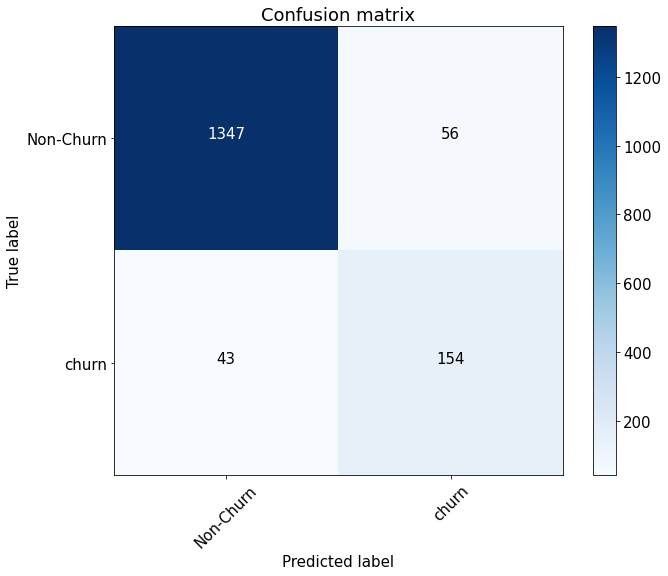

In [47]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [48]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9627411891125254

In [49]:
score_compare = pd.concat([score_compare, pd.DataFrame({
    "method": ['median'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})], axis=0, ignore_index=True)

score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.933178,0.641791,0.654822,0.648241
1,median,0.962741,0.734597,0.786802,0.759804


### 3. Повторить п.2, но используя уже не медиану, а max

#### Выполняем непосредственно само задание. 
Модифицируем код функции get_user_embedding таким образом, чтобы считалось максимальное значение

In [50]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [51]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.190961,0.146856,0.451129,0.000000,0.000000,0.211219,0.016548,0.087819,0.318427,0.181980,0.119737,0.039047,0.000000,0.047593,0.319444,0.027307,0.014144,0.264529,0.401621,0.0,0.169405,0.344500,0.169647
1,u108690,0.0,0.0,0.074508,0.213766,0.492237,0.011177,0.015871,0.093179,0.000000,0.064865,0.282432,0.297756,0.042351,0.025914,0.037195,0.106922,0.172196,0.000000,0.153764,0.130809,0.094049,0.0,0.031270,0.024759,0.241536
2,u108339,0.0,0.0,0.166368,0.119383,0.360457,0.000000,0.126586,0.168933,0.019379,0.000000,0.133761,0.376874,0.049130,0.021854,0.025538,0.077799,0.194917,0.025065,0.109252,0.168126,0.251492,0.0,0.000000,0.015350,0.198923


In [52]:
X = pd.merge(user_embeddings_max, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.190961,0.146856,0.451129,0.000000,0.000000,0.211219,0.016548,0.087819,0.318427,0.181980,0.119737,0.039047,0.000000,0.047593,0.319444,0.027307,0.014144,0.264529,0.401621,0.0,0.169405,0.344500,0.169647,0
1,u108690,0.0,0.0,0.074508,0.213766,0.492237,0.011177,0.015871,0.093179,0.000000,0.064865,0.282432,0.297756,0.042351,0.025914,0.037195,0.106922,0.172196,0.000000,0.153764,0.130809,0.094049,0.0,0.031270,0.024759,0.241536,1
2,u108339,0.0,0.0,0.166368,0.119383,0.360457,0.000000,0.126586,0.168933,0.019379,0.000000,0.133761,0.376874,0.049130,0.021854,0.025538,0.077799,0.194917,0.025065,0.109252,0.168126,0.251492,0.0,0.000000,0.015350,0.198923,1


In [53]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], test_size = 0.20, random_state=29)

In [54]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([1.54627737e-02, 2.38606219e-02, 7.82327944e-01, 3.72721090e-03,
       1.35786818e-01, 9.78602978e-02, 1.93053560e-02, 9.73943994e-05,
       1.21164369e-01, 2.52214962e-04])

#### Рассчитаем Precision, Recall, F_score

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.320874, F-Score=0.722, Precision=0.695, Recall=0.751


Confusion matrix, without normalization
[[1338   65]
 [  50  147]]


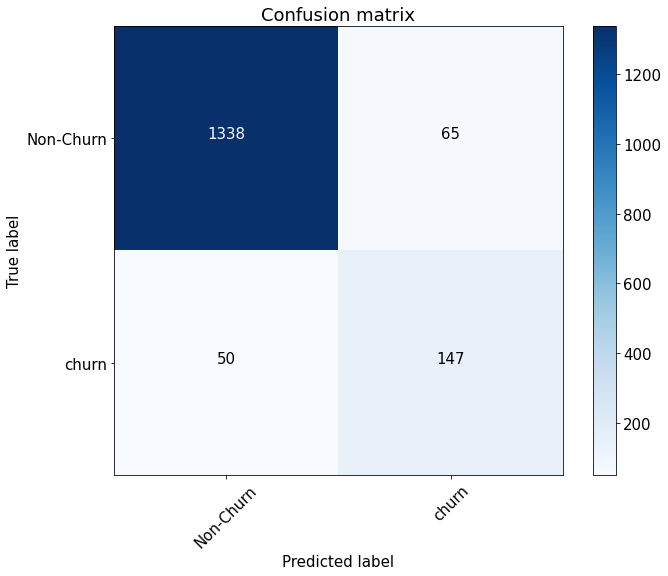

In [57]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9618800901621254

In [59]:
score_compare = pd.concat([score_compare, pd.DataFrame({
    "method": ['max'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})], axis=0, ignore_index=True)

score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.933178,0.641791,0.654822,0.648241
1,median,0.962741,0.734597,0.786802,0.759804
2,max,0.961880,0.694836,0.751269,0.721951


### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [60]:
score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.933178,0.641791,0.654822,0.648241
1,median,0.962741,0.734597,0.786802,0.759804
2,max,0.961880,0.694836,0.751269,0.721951


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Метод основанный на медиане дает более эффективное обучение. Я понимаю медиану так - это некоторое центральное значение, к которому стремится весь ряд данных, своего рода мода среди непрерывного (не категориального) ряда значений. Среднее же значение не всегда является центральным (модным). Полагаю это и есть объяснение того, что при медиане обучение эффективнее. Метод обучения при максимальных значениях векторов также дает высокие метрики, вероятно это связано с тем, что значения медианы и максимума близки друг к другу.